# 2D Wavelet Transformation in PyTorch
*Thomas Viehmann <tv@lernapparat.de>*

The other day I got a question how to do wavelet transformation in PyTorch in a way that allows to compute gradients (that is gradients of outputs w.r.t. the inputs, probably not the coefficients). I like Pytorch and I happen to have a certain fancy for wavelets as well, so here we go.

We take an image of the Zuse Z4.
![Z4](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bc/Zuse-Z4-Totale_deutsches-museum.jpg/315px-Zuse-Z4-Totale_deutsches-museum.jpg)
<center>(Image Credit: Clemens Pfeiffer, CC-BY 2.5 at [Wikimedia](https://commons.wikimedia.org/wiki/File:Zuse-Z4-Totale_deutsches-museum.jpg))</center>

We will make use of PyTorch (of course) and the excellent [PyWavelet aka pywt module](http://pywavelets.readthedocs.io/). The latter includes a large library of wavelet coefficients and also functions to perform wavelet transforms. We only use the former.
So let's import stuff.

In [1]:
import pywt
from matplotlib import pyplot
%matplotlib inline
import numpy
from PIL import Image
import urllib.request
import io
import torch
import torch.nn as nn

URL = 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/bc/Zuse-Z4-Totale_deutsches-museum.jpg/315px-Zuse-Z4-Totale_deutsches-museum.jpg'


Let us see what wavelets are available:

In [2]:
print(pywt.families())

['haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus', 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor']


For this demo we will use the Biorthogonal 2.2 Wavelets. As we will not properly deal with boundaries, this is a compromise between not using the (almost trivial) Haar wavelet and using more elaborate but larger wavelets.
When adapting this code to other wavelets, you will need to adjust the padding. To use multiple channels (color images) you would want to `.view` the channels into the batch dimension.

The basic idea is that for each coordinate direction you apply a high pass and a low pass filter with a stride of 2, and one can take PyTorch convolutions for this purpose.  With orthogonal wavelets, you would feed the same wavelet into the transposed convolution for decoding, with biorthogonal wavelets, you have a separate set of coefficients for decoding.
I adjust the filters so that they are ready for use with PyTorch convolutions, i.e. with correlations of the form $Y_{k,l} = \sum \psi_ij X_{i+k,j+l}$.

We take a look at the wavelets.


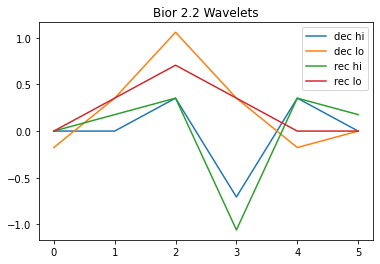

In [3]:
w=pywt.Wavelet('bior2.2')
pyplot.plot(w.dec_hi[::-1], label="dec hi")
pyplot.plot(w.dec_lo[::-1], label="dec lo")
pyplot.plot(w.rec_hi, label="rec hi")
pyplot.plot(w.rec_lo, label="rec lo")
pyplot.title("Bior 2.2 Wavelets")
pyplot.legend()
dec_hi = torch.tensor(w.dec_hi[::-1]) 
dec_lo = torch.tensor(w.dec_lo[::-1])
rec_hi = torch.tensor(w.rec_hi)
rec_lo = torch.tensor(w.rec_lo)


In [4]:
dec_hi.shape

torch.Size([6])

Let us have a black and white picture:

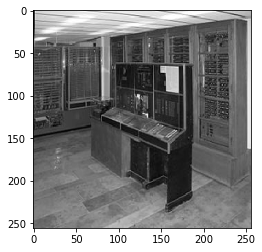

In [5]:
imgraw = Image.open(io.BytesIO(urllib.request.urlopen(URL).read())).resize((256,256))
img = numpy.array(imgraw).mean(2)/255
img = torch.from_numpy(img).float()
pyplot.figure()
pyplot.imshow(img, cmap=pyplot.cm.gray)


We define the tensor product filter banks, i.e. we multiply filters for the two coordinates.

In [6]:
filters = torch.stack([dec_lo.unsqueeze(0)*dec_lo.unsqueeze(1),
                       dec_lo.unsqueeze(0)*dec_hi.unsqueeze(1),
                       dec_hi.unsqueeze(0)*dec_lo.unsqueeze(1),
                       dec_hi.unsqueeze(0)*dec_hi.unsqueeze(1)], dim=0)

inv_filters = torch.stack([rec_lo.unsqueeze(0)*rec_lo.unsqueeze(1),
                           rec_lo.unsqueeze(0)*rec_hi.unsqueeze(1),
                           rec_hi.unsqueeze(0)*rec_lo.unsqueeze(1),
                           rec_hi.unsqueeze(0)*rec_hi.unsqueeze(1)], dim=0)


In [7]:
torch.allclose(filters[2].view(-1), filters[3].view(-1))


False

In [8]:
filters.shape, filters[:,None].shape

(torch.Size([4, 6, 6]), torch.Size([4, 1, 6, 6]))

In [9]:
cwt = nn.Conv2d(1, 4, kernel_size=6, stride=2, bias=False)
cwt.weight.data.shape

torch.Size([4, 1, 6, 6])

In [10]:
cwt.weight = nn.Parameter(filters[:,None])
cwt

Conv2d(1, 4, kernel_size=(6, 6), stride=(2, 2), bias=False)

In [12]:
# padded = torch.nn.functional.pad(vimg,(2,2,2,2))

# torch.testing.assert_allclose(
#     torch.nn.functional.conv2d(padded, filters[:,None],stride=2),
#     cwt(padded)
# )
# vimg.shape, cwt(padded).shape

In [13]:
iwt = nn.ConvTranspose2d(4, 4, kernel_size=6, stride=2, bias=False)
iwt.weight = nn.Parameter(inv_filters[:,None])
iwt

ConvTranspose2d(4, 4, kernel_size=(6, 6), stride=(2, 2), bias=False)

In [14]:
iwt(cwt(vimg)).shape

NameError: name 'vimg' is not defined

In [15]:
vres = cwt(padded)
h = vres.size(2)
w = vres.size(3)
res = vres.view(-1,h//2,2,w//2).transpose(1,2).contiguous().view(-1,4,h//2,w//2).clone()
res.shape

NameError: name 'padded' is not defined

In [16]:
torch.testing.assert_allclose(
    iwt(iwt(res)),
    vimg
)

#cwt(padded).shape

NameError: name 'res' is not defined

We can now define the wavelet transform and its inverse using pytorch conv2d and conv_transpose2d.
For the recursion, we only continue to process the top left component with two low passes.
This is different from taking tensor-product of the full 1d wavelet basis in that we do not further refine one low-pass coordinate when the other coordinate has taken the high-pass.

This seems to be the convention used e.g. JPEG compression. I seem to remember that there are also stability reasons to keep the aspect ratio bounded for multi-resolution analysis, but I do not have a good reference to point to.

On the component with two low passes, one then applies another transform up to a desired level. We rearrange the four filter output into an image of the same size. To allow for full reconstruction, we would need to deal with the boundaries - either by adapting the wavelets or by padding more - but we do not do this.

As PyTorch's `nn` module does this by default, we consider `batch x channels x height x width`.

In [42]:
def wt(vimg, levels=1):
    h = vimg.size(2)
    w = vimg.size(3)
    padded = torch.nn.functional.pad(vimg,(2,2,2,2))
    print('padded.shape', padded.shape)
    res = torch.nn.functional.conv2d(padded, filters[:,None],stride=2)
    res1 = res.clone()
    print('res.shape', res.shape)
    if levels>1:        
        res[:,:1] = wt(res[:,:1],levels-1)
    res = res.view(-1,2,h//2,w//2).transpose(1,2).contiguous().view(-1,1,h,w)
    print('after res.shape', res.shape)
    return res#, res1

Similar, we do the reconstruction (Inverse Wavelet Transform) using the `conv_transpose2d` function. We drop the excess coefficients.

In [43]:
[0, 1, 2, 3, 4][:1]

[0]

In [44]:
def iwt(vres, levels=1):
    h = vres.size(2)
    w = vres.size(3)
    res = vres.view(-1,h//2,2,w//2).transpose(1,2).contiguous().view(-1,4,h//2,w//2).clone()
    print(res.shape)
    if levels>1:
        print(res[:,:1].shape)
        res[:,:1] = iwt(res[:,:1], levels=levels-1)
    print('Before conv_transpose2d', res.shape)
    res = torch.nn.functional.conv_transpose2d(res, inv_filters[:,None],stride=2)
    print('res after convtranspoise', res.shape)
    print(res.shape)
    res = res[:,:,2:-2,2:-2]
    return res

We can do this on our image. First the decomposition:

padded.shape torch.Size([1, 1, 260, 260])
res.shape torch.Size([1, 4, 128, 128])
after res.shape torch.Size([1, 1, 256, 256])


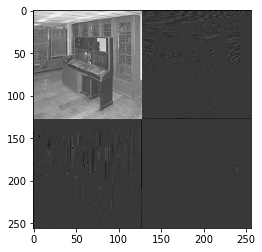

In [46]:
vimg = img[None,None]
res = wt(vimg,1)
pyplot.figure()
pyplot.imshow(res[0,0].data.numpy(),cmap=pyplot.cm.gray)

torch.Size([1, 4, 128, 128])
Before conv_transpose2d torch.Size([1, 4, 128, 128])
res after convtranspoise torch.Size([1, 1, 260, 260])
torch.Size([1, 1, 260, 260])


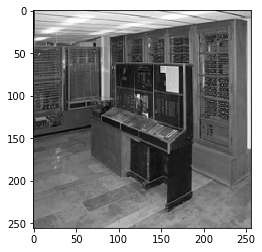

In [49]:
rec = iwt(res, levels=1)
pyplot.imshow(rec[0,0].data.numpy(),cmap=pyplot.cm.gray)

We can see where the reconstruction errors are:

In [50]:
torch.testing.assert_allclose(rec, vimg)

AssertionError: Tensor-likes are not close!

Mismatched elements: 1525 / 65536 (2.3%)
Greatest absolute difference: 0.12756341695785522 at index (0, 0, 0, 255) (up to 1e-05 allowed)
Greatest relative difference: 2.0625113047641515 at index (0, 0, 12, 1) (up to 0.0001 allowed)

In [ ]:
pyplot.imshow((rec-vimg).data[0,0].numpy(), cmap=pyplot.cm.gray)
pyplot.colorbar()

This concludes our little tour on how to use wavelets with PyTorch.

I recommend to also look at [scattering networks](https://github.com/edouardoyallon/scalingscattering) for an application of fixed MRA in deep learning.

I appreciate your feedback at <tv@lernapparat.de>.

Thomas Viehmann